In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format

import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "C:/Users/USER/.keras/datasets/jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
df = df[5: :6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

wv = df["wv (m/s)"]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
max_wv = df["max. wv (m/s)"]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0


wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)')*np.pi / 180
df["Wx"] = wv * np.cos(wd_rad)
df["Wy"] = wv * np.sin(wd_rad)
df["max Wx"] = max_wv * np.cos(wd_rad)
df["max Wy"] = max_wv * np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day
df["Day sin"] = np.sin(timestamp_s * (2 * np.pi /day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi /day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

fft = tf.signal.rfft(df["T (degC)"])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df["T (degC)"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h / (hours_per_year)
f_per_year = f_per_dataset / years_per_dataset

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [2]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        #Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in 
                                         enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                              enumerate(train_df.columns)}
        
        #Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = self.input_width + self.shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

## w1
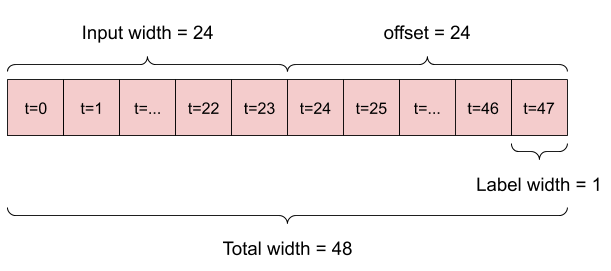

In [3]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, 
               label_columns=["T (degC)"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

## w2
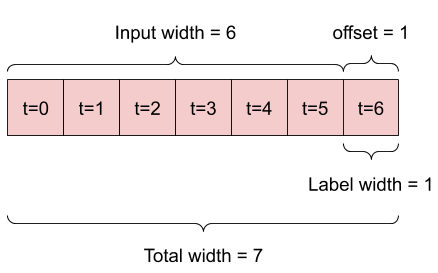

In [4]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                label_columns=["T (degC)"])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

## split_window
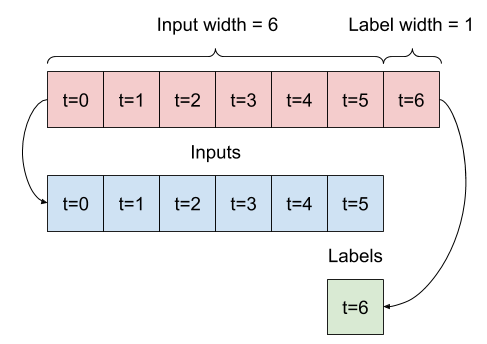

self.
- `self.label_columns`
- `self.input_width`
- `self.label_width`

## split_window

In [5]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, column_indices[name]] for name in self.label_columns],
                 axis=-1)
    
    # Slicing doesn;t preserve static shape information, so set the shapes
    # mannually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

Try it(`split_window`) out:

In [6]:
# Stack three slices, the length of the toal window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
    np.array(train_df[100: 100+w2.total_window_size]),
    np.array(train_df[200: 200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


## plot
visualize the split window

In [7]:
w2.example = example_inputs, example_labels

- plot_col
- 조희승 선생님 dacrew

In [8]:
def plot(self, model=None, plot_col="T (degC)", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label="Inputs", marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                   edgecolors='k', label="Labels", c="#2ca02c", s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                   marker='X', edgecolors='k', label='Predictions',
                   c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
            
    plt.xlabel('Time [h]')
    
WindowGenerator.plot = plot

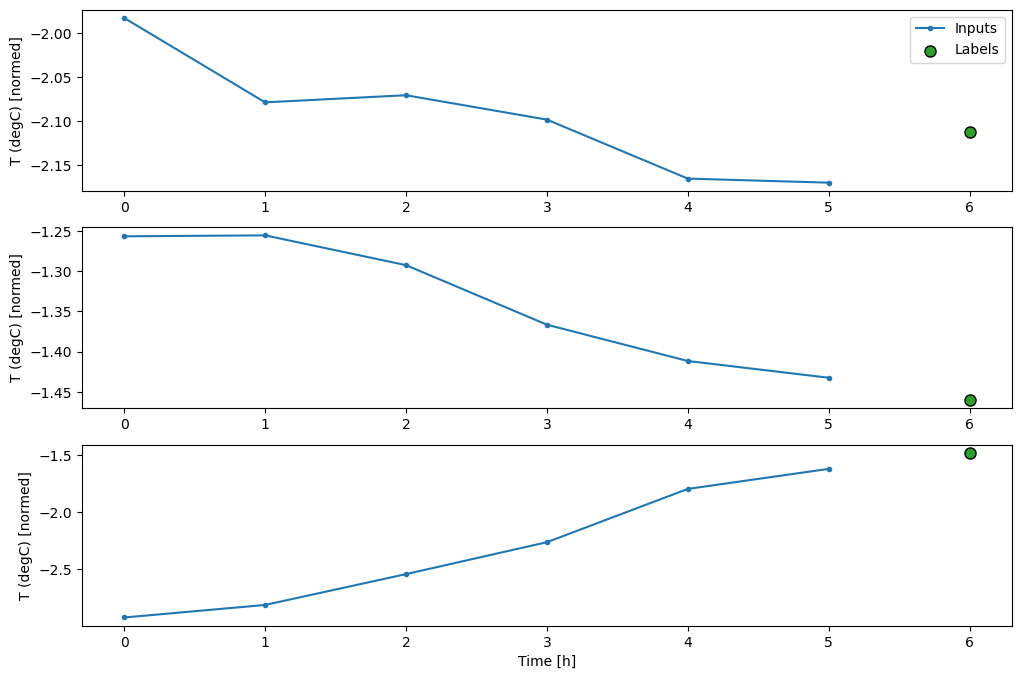

In [9]:
w2.plot()

since example window `w2` only has `T (degC)` for the label in configuration, you can not plot other columns such as `p (mbar)` like the above figure:

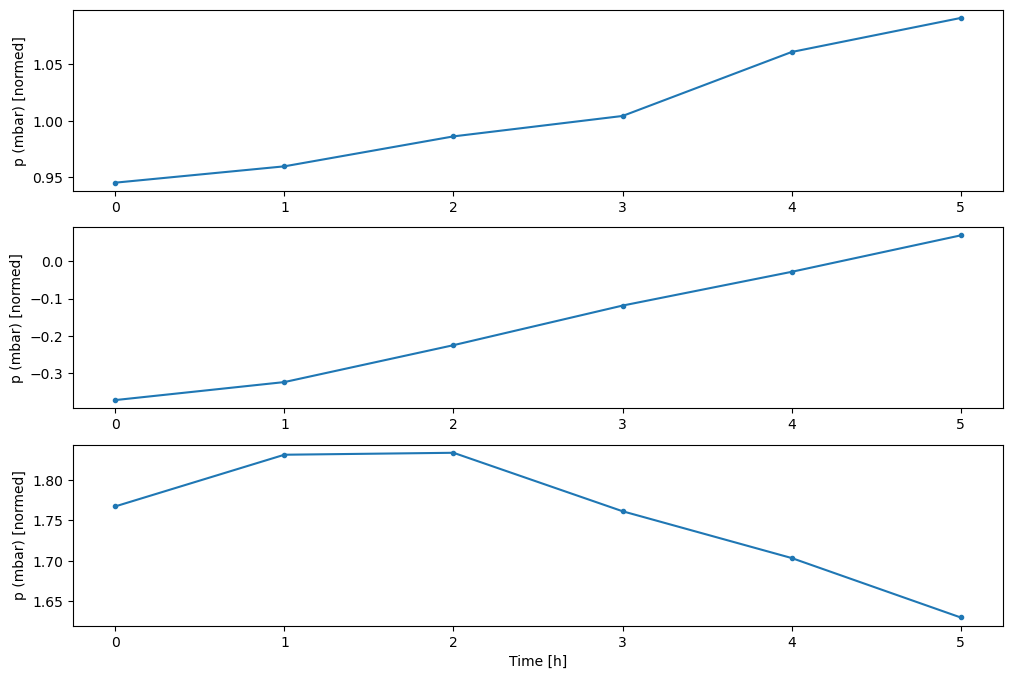

In [10]:
w2.plot(plot_col='p (mbar)')

## make_dataset
takse a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)`pairs using `tf.keras.utils.timeseries_dataset_from_array` function.

In [11]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32)
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

## Add 

- Add **properties** for accessing them as `tf.data.Dataset`s using the `make_dataset` method. 
> train_df, val_df, test_df에 make_dataset 적용
- Add a **standard example batch** for easy access and plotting:

 ?
- getattr():
- next():
- iter():

In [12]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of 'inputs, labels' for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

If you get an access to `tf.data.Dataset` object, you can easily **iterate** over the data.
> In the above cell the `WindowGenerator` object gives you a access to `tf.data.Dataset` object. 

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [13]:
#Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iteratirng over a `dataset` yields concrete batches:

In [14]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## single step model

model that predicts the `T (degC)` value on hour into the future.

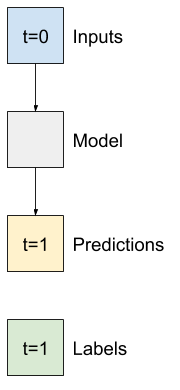

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [15]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

In [16]:
#single_step_window.example

## Baseline
performance baseline

- task: predict temperature one hour into the furture, given the current value of all features. The current values include the current temperature.


### Baseline model 
Baseline model that returns the **current temperature** as the  prediction. Predicting 'No change'.
> This is reasonable baseline since temperature changes slowly.

?
- tf.newaxis:

In [17]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        # current temperature를 return하기 때문에
        # inputs에서 result를 가져온다.
        result = inputs[:, :, self.label_index] 
        return result[:, :, tf.newaxis]

Instantiate and evaluate above model:

In [18]:
baseline = Baseline(label_index=column_indices["T (degC)"])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [19]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


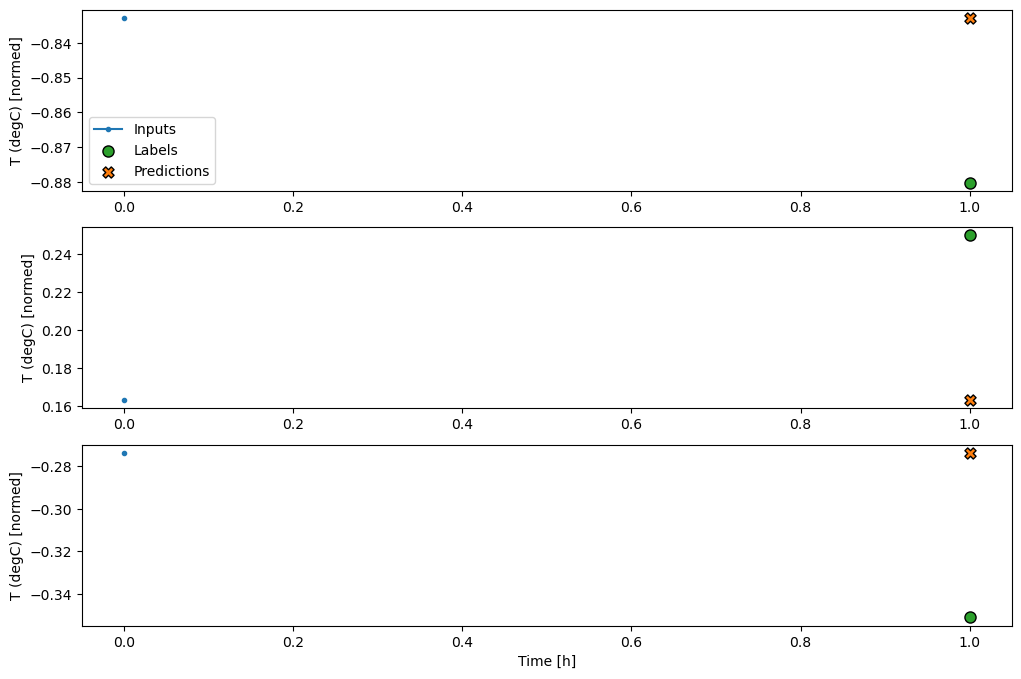

In [20]:
single_step_window.plot(baseline)

## wide_window

Generate a wider window windows 24hours of consecutive inputs  and labels at a time.

In [21]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1,
               label_columns=["T (degC)"])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

Can apply this wide window to the baseline model since:
- inputs and labels have the **same number of time steps**
- baseline just forwards the input to the output

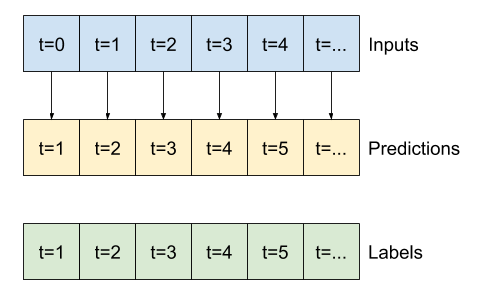

In [22]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


plotting the baseline model's predictions:
> Below figure only shows the temperature.

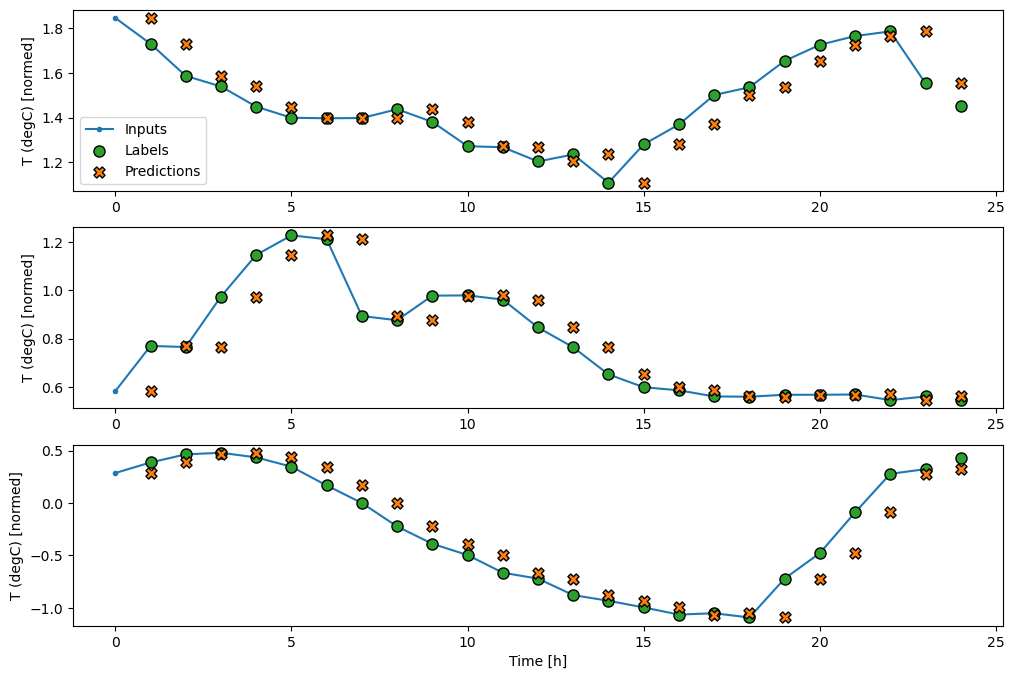

In [23]:
wide_window.plot(baseline)

### Linear model

the simplest **trainable** model

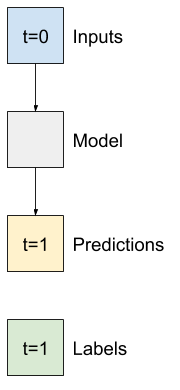

In [24]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [27]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [30]:
MY_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=patience,
                                                     mode='min')
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MY_EPOCHS,
             validation_data=window.val,
             callbacks =[early_stopping])
    
    return history

Train the `linear model` and evaluate its performance:

In [31]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0978 - mean_absolute_error: 0.1976 - val_loss: 0.0127 - val_mean_absolute_error: 0.0850
Epoch 2/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0110 - mean_absolute_error: 0.0778 - val_loss: 0.0098 - val_mean_absolute_error: 0.0737
Epoch 3/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0097 - mean_absolute_error: 0.0726 - val_loss: 0.0092 - val_mean_absolute_error: 0.0709
Epoch 4/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0095 - mean_absolute_error: 0.0714 - val_loss: 0.0091 - val_mean_absolute_error: 0.0700
Epoch 5/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0094 - mean_absolute_error: 0.0710 - val_loss: 0.0089 - val_mean_absolute_error: 0.0696
Epoch 6/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0089 - val_mean_absolute_error: 0.0698
Epoc

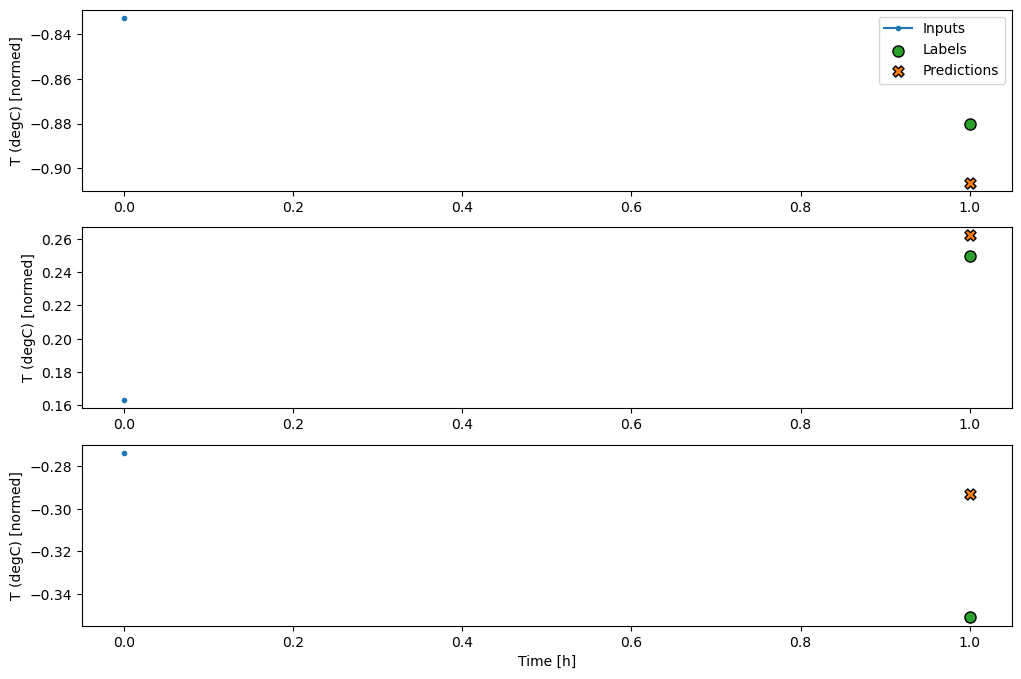

In [34]:
single_step_window.plot(linear)